In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
import numpy as np
import copy
from autograd_lib import autograd_lib
from collections import defaultdict
import math

# define preferred pytorch device (gpu, if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using " + device + " device")

Using cuda device


In [3]:
# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# set labels to random values
MNIST_trainset.targets = torch.randint(0, 10, MNIST_trainset.targets.shape)
MNIST_testset.targets = torch.randint(0, 10, MNIST_testset.targets.shape)

# define train and test data loaders
train_loader = DataLoader(MNIST_trainset, batch_size=600, shuffle=True, num_workers=2)
test_loader = DataLoader(MNIST_testset, batch_size=100, shuffle=False, num_workers=2)

In [4]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def evaluate_test_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    epoch_test_loss = 0.0
    for batch, (images, labels) in enumerate(dataloader): 
        images = images.to(device)
        labels = labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        epoch_test_loss += loss.item() / len(dataloader)
    return epoch_test_loss

In [5]:
def train_dnn(dataloader, model):
    model.train()

    epoch_training_loss = 0.0
    for batch, (images, labels) in enumerate(dataloader): 
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item() / len(dataloader)
        
    return epoch_training_loss

In [6]:
def train_and_evaluate(train_loader, test_loader, model):
    max_epochs = 50
    training_loss = []
    test_loss = []
    
    for epoch in range(max_epochs):
        epoch_training_loss = train_dnn(train_loader, model)
        training_loss.append(epoch_training_loss)
        epoch_test_loss = evaluate_test_loss(test_loader, model)
        test_loss.append(epoch_test_loss)

        if (epoch % 25 == 0) or (epoch == (epochs-1)):
            print("Epoch " + str(epoch) + ", training loss: " + str(epoch_training_loss) 
                + ", test loss: " + str(epoch_test_loss))
            
    return training_loss, test_loss

In [7]:
dnn1 = DNN().to(device)
print(dnn1)
# n_param=[]
# for i in dnn1.parameters():
#     n_param.append(torch.numel(i))
# print(f'Total no of parameters:{np.sum(n_param)}')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn1.parameters())#,lr = 0.0001,weight_decay=1e-4)

print("Training model on random MNIST...")
training_loss, test_loss = train_and_evaluate(train_loader, test_loader, dnn1)

DNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Training model on random MNIST...
Epoch 0, training loss: 2.3048468708992007, test loss: 2.303129689693452
Epoch 20, training loss: 2.0835634016990663, test loss: 2.4326731395721435
Epoch 40, training loss: 1.8115707445144658, test loss: 2.694615700244903
Epoch 49, training loss: 1.7221118366718295, test loss: 2.806899161338806


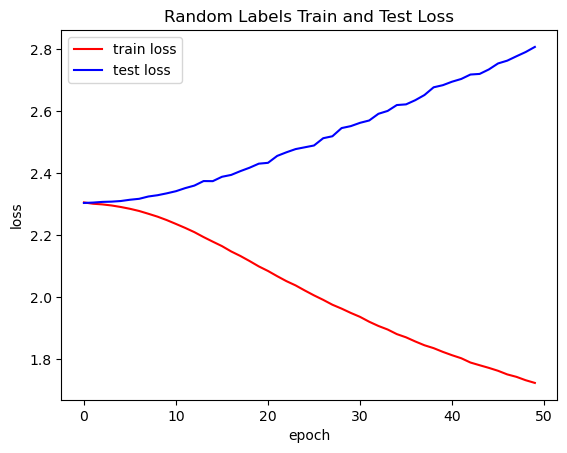

In [12]:
plt.plot(training_loss, color='red')
plt.plot(test_loss, color='blue')
plt.legend(["train loss", "test loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Random Labels Train and Test Loss')
plt.savefig('randomLabel.png')
plt.show()


## Generalization

In [5]:
# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# set labels to random values
MNIST_trainset.targets = torch.randint(0, 10, MNIST_trainset.targets.shape)
MNIST_testset.targets = torch.randint(0, 10, MNIST_testset.targets.shape)

# define train and test data loaders
train_loader = DataLoader(MNIST_trainset, batch_size=600, shuffle=True, num_workers=2)
test_loader = DataLoader(MNIST_testset, batch_size=100, shuffle=False, num_workers=2)

In [55]:
class DNN(nn.Module):
    def __init__(self, h_layer):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, h_layer)
        self.fc2 = nn.Linear(h_layer, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [56]:
def params_count(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

num_models = 10
models = []
model_param_counts = []

for i in range(num_models): 
    models.append(DNN(h_layer=((i+1)*2)).to(device))
    model_param_counts.append(params_count(models[i]))
    print("Model", i, ", number of parameters:", model_param_counts[i])

Model 0 , number of parameters: 1600
Model 1 , number of parameters: 3190
Model 2 , number of parameters: 4780
Model 3 , number of parameters: 6370
Model 4 , number of parameters: 7960
Model 5 , number of parameters: 9550
Model 6 , number of parameters: 11140
Model 7 , number of parameters: 12730
Model 8 , number of parameters: 14320
Model 9 , number of parameters: 15910


In [57]:
def evaluate_test_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    epoch_test_loss = 0.0
    for batch, (images, labels) in enumerate(dataloader): 
        images = images.to(device)
        labels = labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        epoch_test_loss += loss.item() / len(dataloader)
    return epoch_test_loss


In [58]:
def evaluate_accuracy(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for images, labels in dataloader: 
        images = images.to(device)
        labels = labels.to(device)
        prediction = model(images)
        y = prediction.data.max(1, keepdim=True)[1]
        correct += y.eq(labels.data.view_as(y)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)
    

In [59]:
def train_dnn(dataloader, model):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    epoch_training_loss = 0.0
    for batch, (images, labels) in enumerate(dataloader): 
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item() / len(dataloader)
        
    return epoch_training_loss

In [61]:
def train_and_evaluate(train_loader, test_loader, model):
    max_epochs = 10
    training_loss = []
    test_loss = []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(max_epochs):
        if epoch < (max_epochs - 1):
            training_loss = train_dnn(train_loader, model)
            # print info
            if (epoch % 5 == 0):
                print("Epoch " + str(epoch) + ", training loss: " + str(training_loss))
                
        else: # record loss and accuracy only on last epoch

            training_loss = train_dnn(train_loader, model)
            test_loss = evaluate_test_loss(test_loader, model)
            train_accuracy = evaluate_accuracy(train_loader, model)
            test_accuracy = evaluate_accuracy(test_loader, model)
            
            # print info
            print("Epoch " + str(epoch) + ", training loss: " + str(training_loss) 
                + ", test loss: " + str(test_loss)
                + ", train accuracy: " + str(train_accuracy) + "%"
                + ", test accuracy: " + str(test_accuracy) + "%")
            
    return training_loss, test_loss, train_accuracy, test_accuracy

In [25]:
#print(models)

In [51]:
plot_data_train_losses = []
plot_data_test_losses = []
plot_data_train_accs = []
plot_data_test_accs = []

for i in range(num_models): 
    print("\nTraining model", i, "on MNIST...")
    training_loss, test_loss, train_accuracy, test_accuracy = train_and_evaluate(train_loader, test_loader, models[i])
    plot_data_train_losses.append(training_loss) 
    plot_data_test_losses.append(test_loss) 
    plot_data_train_accs.append(train_accuracy)
    plot_data_test_accs.append(test_accuracy) 
print("Done.")


Training model 0 on MNIST...
Epoch 0, training loss: 2.354349327087402
Epoch 5, training loss: 2.3025477242469776
Epoch 9, training loss: 2.3011111855506887, test loss: 2.3046358060836787, train accuracy: 10.766666666666667%, test accuracy: 9.83%

Training model 1 on MNIST...
Epoch 0, training loss: 2.3184539866447467
Epoch 5, training loss: 2.3025872468948365
Epoch 9, training loss: 2.302301723957061, test loss: 2.302625942230224, train accuracy: 10.236666666666666%, test accuracy: 10.2%

Training model 2 on MNIST...
Epoch 0, training loss: 2.310668010711669
Epoch 5, training loss: 2.3012483954429626
Epoch 9, training loss: 2.2993387269973757, test loss: 2.304722056388854, train accuracy: 11.275%, test accuracy: 10.29%

Training model 3 on MNIST...
Epoch 0, training loss: 2.3099944210052485
Epoch 5, training loss: 2.300510761737825
Epoch 9, training loss: 2.298408641815185, test loss: 2.3061030054092404, train accuracy: 11.478333333333333%, test accuracy: 10.25%

Training model 4 on 

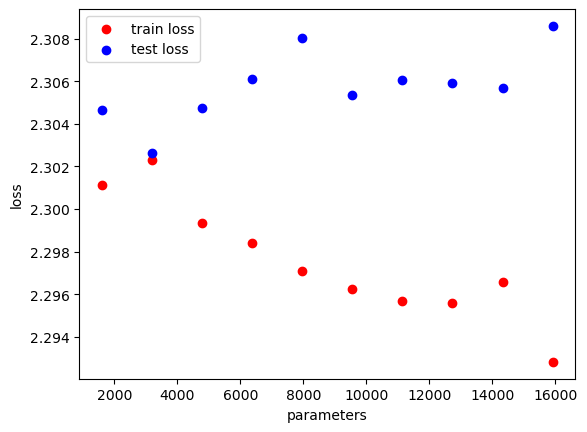

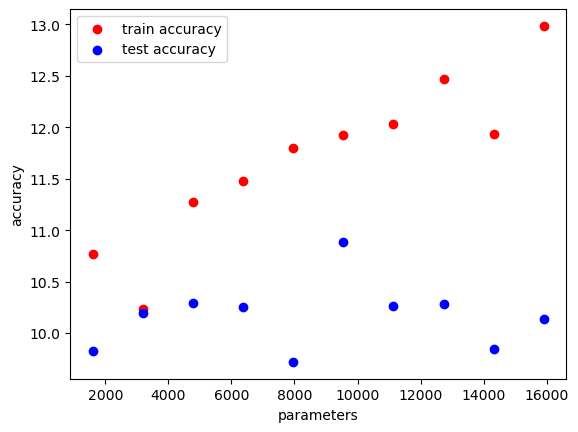

In [71]:

plt.scatter(model_param_counts, plot_data_train_losses, color='red', marker='o')
plt.scatter(model_param_counts, plot_data_test_losses, color='blue', marker='o')
plt.legend(["train loss", "test loss"])
plt.xlabel("parameters")
plt.ylabel("loss")
plt.savefig('LossComparisonVsParameter.png')
plt.show()
plt.show()
plt.scatter(model_param_counts, plot_data_train_accs, color='red', marker='o')
plt.scatter(model_param_counts, plot_data_test_accs, color='blue', marker='o')
plt.legend(["train accuracy", "test accuracy"])
plt.xlabel("parameters")
plt.ylabel("accuracy")
plt.savefig('AccuracyComparisonVsParameter.png')
plt.show()


In [53]:
print(model_param_counts)
print(plot_data_test_losses)

[1600, 3190, 4780, 6370, 7960, 9550, 11140, 12730, 14320, 15910]
[2.302579813003539, 2.3041364884376527]


### Flatness vs Generalization

In [72]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [73]:
dnn_model_A = DNN().to(device)
dnn_model_B = DNN().to(device)

In [74]:
def evaluate_accuracy(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for input_data, labels in dataloader: 
        input_data = input_data.to(device)
        labels = labels.to(device)
        y_pred = model(input_data)
        y_pred_one_hot = y_pred.data.max(1, keepdim=True)[1]
        correct += y_pred_one_hot.eq(labels.data.view_as(y_pred_one_hot)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)

In [75]:
def evaluate_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    epoch_test_loss = 0.0
    for batch, (images, labels) in enumerate(dataloader): 
        images = images.to(device)
        labels = labels.to(device)

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        epoch_test_loss += loss.item() / len(dataloader)
    return epoch_test_loss

In [79]:
def train_dnn(dataloader, model, epochs=10, lr=1e-3):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # set model to train mode
    model.train()

    for epoch in range(epochs):
        epoch_training_loss = 0.0
        for batch, (images, labels) in enumerate(dataloader): 
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            prediction = model(images)
            loss = loss_fn(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_training_loss += loss.item() / len(dataloader)
        
        # print info
        if (epoch % 5 == 0):
            print("Epoch " + str(epoch) + ", training loss: " + str(epoch_training_loss))



In [85]:
def interpolate_models(model_A, model_B, alpha):
    interpolated_model = DNN().to(device)
    # set weights
    for p in interpolated_model.state_dict():
        p_a = model_A.state_dict()[p].cpu().numpy()
        p_b = model_B.state_dict()[p].cpu().numpy()
        interpolated_model.state_dict()[p][:] = torch.Tensor((1-alpha)*p_a + alpha*p_b)
    
    return interpolated_model.to(device)

In [91]:
alpha_values = np.linspace(0, 1, 25)
plot_data_train_losses = []
plot_data_test_losses = []
plot_data_train_accs = []
plot_data_test_accs = []

# train models
print("Training model A on MNIST...")
train_dnn(train_loader, dnn_model_A, lr=1e-3)

print("\nTraining model B on MNIST...")
train_dnn(train_loader, dnn_model_B, lr=1e-2)



Training model A on MNIST...
Epoch 0, training loss: 2.292431633472442
Epoch 5, training loss: 2.28952821969986

Training model B on MNIST...
Epoch 0, training loss: 2.3026536393165586
Epoch 5, training loss: 2.3021461343765255


In [86]:
# evaluate interpolated models
print("\nEvaluating interpolated models...")
for alpha in alpha_values: 
    print("alpha:", alpha)
    interpolated_model = interpolate_models(dnn_model_A, dnn_model_B, alpha)
    training_loss = evaluate_loss(train_loader, interpolated_model)
    test_loss = evaluate_loss(test_loader, interpolated_model)
    train_accuracy = evaluate_accuracy(train_loader, interpolated_model)
    test_accuracy = evaluate_accuracy(test_loader, interpolated_model)
    
    plot_data_train_losses.append(training_loss) 
    plot_data_test_losses.append(test_loss) 
    plot_data_train_accs.append(train_accuracy)
    plot_data_test_accs.append(test_accuracy) 
print("Done.")


Evaluating interpolated models...
alpha: -1.0
alpha: -0.9166666666666666
alpha: -0.8333333333333334
alpha: -0.75
alpha: -0.6666666666666667
alpha: -0.5833333333333334
alpha: -0.5
alpha: -0.41666666666666674
alpha: -0.33333333333333337
alpha: -0.25
alpha: -0.16666666666666674
alpha: -0.08333333333333337
alpha: 0.0
alpha: 0.08333333333333326
alpha: 0.16666666666666652
alpha: 0.25
alpha: 0.33333333333333326
alpha: 0.4166666666666665
alpha: 0.5
alpha: 0.5833333333333333
alpha: 0.6666666666666665
alpha: 0.75
alpha: 0.8333333333333333
alpha: 0.9166666666666665
alpha: 1.0
Done.


ValueError: x and y must have same first dimension, but have shapes (25,) and (0,)

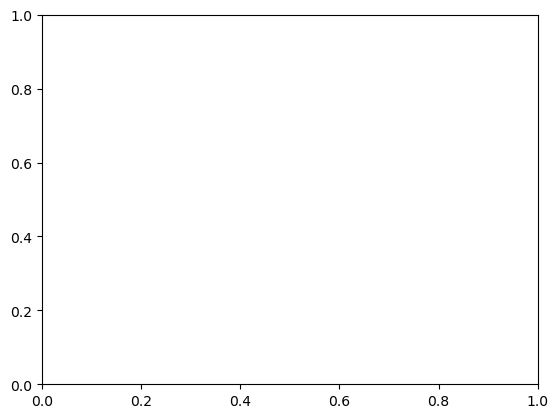

In [93]:
# normalize scales for loss and accuracy
max_loss = 0
max_acc = 0

for l in plot_data_train_losses + plot_data_test_losses:
    if l > max_loss: 
        max_loss = l

for a in plot_data_train_accs + plot_data_test_accs:
    if a > max_acc: 
        max_acc = a
for i in range(len(plot_data_train_losses)): 
    plot_data_train_losses[i] /= max_loss

for i in range(len(plot_data_test_losses)): 
    plot_data_test_losses[i] /= max_loss

for i in range(len(plot_data_train_accs)): 
    plot_data_train_accs[i] /= max_acc
    
for i in range(len(plot_data_test_accs)): 
    plot_data_test_accs[i] /= max_acc

# plot loss and accuracy, for both train and test
plt.plot(alpha_values, plot_data_train_losses, color='blue')
plt.plot(alpha_values, plot_data_test_losses, color='darkblue', linestyle="--")
plt.plot(alpha_values, plot_data_train_accs, color='red')
plt.plot(alpha_values, plot_data_test_accs, color='darkred', linestyle="--")
plt.legend(["trainLoss", "testLoss", "trainAccuracy", "testAccuracy"])
plt.xlabel("alpha")
plt.ylabel("Accuracy/ Loss")
plt.savefig('interpolatedModels.png')
plt.show()

### Sensitivity

In [94]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib
import torch.nn.functional as F     # Contains all the functions in the torch.nn library


# define preferred pytorch device (gpu, if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using " + device + " device")

Using cuda device


In [95]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 10))

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

In [96]:
# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# define train and test data loaders
trainset_loader = DataLoader(MNIST_trainset, batch_size=64, shuffle=True, num_workers=2)
testset_loader = DataLoader(MNIST_testset, batch_size=64, shuffle=False, num_workers=2)

In [97]:
# function to evaluate model accuracy against the provided dataset
def evaluate_accuracy(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for input_data, labels in dataloader: 
        input_data = input_data.to(device)
        labels = labels.to(device)
        y_pred = model(input_data)
        y_pred_one_hot = y_pred.data.max(1, keepdim=True)[1]
        correct += y_pred_one_hot.eq(labels.data.view_as(y_pred_one_hot)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)
    

# function to evaluate model loss against dataset (without training the params)
def evaluate_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # compute epoch loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss
    
    
# function to train a model with the provided dataset for one epoch. Returns training loss and sensitivity
def train_dnn(dataloader, model, lr=1e-3):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # set model to train mode
    model.train()
    
    epoch_training_loss = 0.0
    epoch_sensitivity = 0.0
    
    for batch, (X_train, y_train) in enumerate(dataloader): 
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # compute model predictions and loss
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
  
        # update sensitivity with batch grad (epoch sensitivity := mean sensitivity across all batches)
        grads_p = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
        epoch_sensitivity += grads_p.norm(2).detach().cpu().item() / len(dataloader)
        
        # perform optimization step
        loss.backward()
        optimizer.step()

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_training_loss += loss.item() / len(dataloader)
    
    return epoch_training_loss, epoch_sensitivity

#torch.autograd.set_detect_anomaly(True)
epochs=10

# store data (one sample per model)
training_loss_data=[]
test_loss_data=[]
training_accuracy_data=[]
test_accuracy_data=[]
sensitivity_data=[]

# training 5 models using 5 different learning rates
learning_rates = [5e-2, 1e-2, 5e-3, 1e-3, 1e-4]

for learning_rate_i in learning_rates:  
    print("Training model with learning rate: ", learning_rate_i)
    
    # store train/test accuracy and loss, and sensitivity, for all epochs
    train_accuracies=[]
    test_accuracies=[]
    train_losses=[]
    test_losses=[]
    sensitivities=[]
    
    # instantiate model, move to device
    model = DNNModel().to(device)

    for epoch in range(10):
        print("epoch:", epoch)
        
        # train model, compute training loss and sensitivity
        training_loss, sensitivity = train_dnn(trainset_loader, model, lr=learning_rate_i)
           
        # evaluate loss on test set
        test_loss = evaluate_loss(testset_loader, model)
        
        # evaluate accuracy on train set
        train_accuracy = evaluate_accuracy(trainset_loader, model)
        
        # evaluate accuracy on test set
        test_accuracy = evaluate_accuracy(testset_loader, model)

        # store epoch stats
        train_losses.append(training_loss)
        train_accuracies.append(train_accuracy)
        sensitivities.append(sensitivity)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    # store mean values for current model
    test_loss_data.append(np.mean(test_losses))
    test_accuracy_data.append(np.mean(test_accuracies))
    training_loss_data.append(np.mean(train_losses))
    training_accuracy_data.append(np.mean(train_accuracies))
    sensitivity_data.append(np.mean(sensitivities))

Training model with learning rate:  0.05
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.01
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.005
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.001
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.0001
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


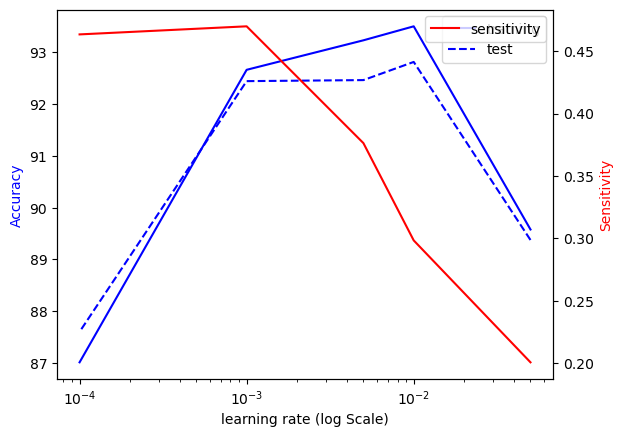

In [99]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('learning rate (log Scale)')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(learning_rates, training_accuracy_data, color='blue', label="training")
ax1.plot(learning_rates, test_accuracy_data, '--', color='blue', label="test")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Sensitivity', color='red')
ax2.plot(learning_rates, sensitivity_data, color='red', label="sensitivity")
ax2.legend()
plt.savefig('LearningRateSensitivity.png')
plt.show()